In [1]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [12]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [3]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.0+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [23]:
csv_path = os.path.join("..", "datasets", "semi_hard_mining_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 21044
val dataset size: 5261


In [24]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "tt" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 21044
validset size: 5261


In [8]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [9]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 658
#batches in validloader : 165


In [5]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [15]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [6]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [13]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [14]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/658 [00:00<?, ?it/s]C:\Users\acali\anaconda3\envs\fvabdetective\lib\site-packages\timm\layers\conv2d_same.py:27: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)
model validating...: 100%|██████████| 165/165 [02:02<00:00,  1.34it/s]


successful weights saving...
epochs: 1, train_loss: 0.35963835905229613, valid_loss: 0.30464560441447025


model validating...: 100%|██████████| 165/165 [01:48<00:00,  1.52it/s]


successful weights saving...
epochs: 2, train_loss: 0.17831707691156665, valid_loss: 0.21831281404152061


model validating...: 100%|██████████| 165/165 [01:49<00:00,  1.50it/s]


successful weights saving...
epochs: 3, train_loss: 0.162105100028398, valid_loss: 0.19908643192188305


model validating...: 100%|██████████| 165/165 [01:34<00:00,  1.75it/s]


epochs: 4, train_loss: 0.1608492601606259, valid_loss: 0.31724343128276594


model validating...: 100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


epochs: 5, train_loss: 0.13696799237609453, valid_loss: 0.30978300404368025


model validating...: 100%|██████████| 165/165 [01:34<00:00,  1.74it/s]


epochs: 6, train_loss: 0.1284039822721282, valid_loss: 0.27538209492058463


model validating...: 100%|██████████| 165/165 [01:46<00:00,  1.55it/s]


successful weights saving...
epochs: 7, train_loss: 0.10271207672348501, valid_loss: 0.14993963345433725


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 8, train_loss: 0.08846878669703079, valid_loss: 0.1949386011696223


model validating...: 100%|██████████| 165/165 [01:32<00:00,  1.79it/s]


successful weights saving...
epochs: 9, train_loss: 0.05702691953232948, valid_loss: 0.13181279342282903


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 10, train_loss: 0.06591108393795947, valid_loss: 0.20201809505621593


model validating...: 100%|██████████| 165/165 [01:31<00:00,  1.81it/s]


epochs: 11, train_loss: 0.06012445637293862, valid_loss: 0.2676479897941604


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


epochs: 12, train_loss: 0.10010298265648106, valid_loss: 0.398516056302822


model validating...: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]


epochs: 13, train_loss: 0.0848913820726531, valid_loss: 0.17917594565360834


model validating...: 100%|██████████| 165/165 [01:30<00:00,  1.82it/s]


successful weights saving...
epochs: 14, train_loss: 0.045953172233555814, valid_loss: 0.10580078533878833


model validating...: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]


epochs: 15, train_loss: 0.03504853306117391, valid_loss: 0.3325126873272838


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 16, train_loss: 0.06433627274776257, valid_loss: 0.15184836259506868


model validating...: 100%|██████████| 165/165 [01:32<00:00,  1.78it/s]


epochs: 17, train_loss: 0.07657643863478375, valid_loss: 0.25792625933589247


model validating...: 100%|██████████| 165/165 [01:30<00:00,  1.83it/s]


epochs: 18, train_loss: 0.04656788112318262, valid_loss: 0.14906543724125984


model validating...: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]


epochs: 19, train_loss: 0.03561006162576038, valid_loss: 0.139490355777018


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 20, train_loss: 0.04354246162829247, valid_loss: 0.11486201560632749


model validating...: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]


epochs: 21, train_loss: 0.031636176834669884, valid_loss: 0.10935121600826582


model validating...: 100%|██████████| 165/165 [01:32<00:00,  1.78it/s]


epochs: 22, train_loss: 0.027027826835500434, valid_loss: 0.10949578418424635


model validating...: 100%|██████████| 165/165 [01:50<00:00,  1.49it/s]


epochs: 23, train_loss: 0.05824758160553623, valid_loss: 0.16618376740000465


model validating...: 100%|██████████| 165/165 [01:40<00:00,  1.63it/s]


epochs: 24, train_loss: 0.04754832584558106, valid_loss: 0.1439210368263902


model validating...: 100%|██████████| 165/165 [01:40<00:00,  1.64it/s]


successful weights saving...
epochs: 25, train_loss: 0.03471310923900738, valid_loss: 0.09923343828907519


model validating...: 100%|██████████| 165/165 [01:36<00:00,  1.71it/s]


epochs: 26, train_loss: 0.024242876431590517, valid_loss: 0.1595490369494214


model validating...: 100%|██████████| 165/165 [01:35<00:00,  1.72it/s]


epochs: 27, train_loss: 0.03229988763805219, valid_loss: 0.18607428873127158


model validating...: 100%|██████████| 165/165 [01:35<00:00,  1.73it/s]


successful weights saving...
epochs: 28, train_loss: 0.028983339019074447, valid_loss: 0.09252435691428906


model validating...: 100%|██████████| 165/165 [01:51<00:00,  1.48it/s]


epochs: 29, train_loss: 0.0204566319311734, valid_loss: 0.16223780871792273


model validating...: 100%|██████████| 165/165 [01:48<00:00,  1.53it/s]

epochs: 30, train_loss: 0.016511200805474923, valid_loss: 0.12551359220436126


<function matplotlib.pyplot.show(close=None, block=None)>

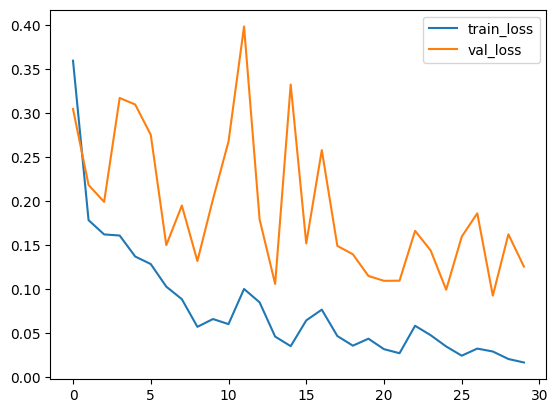

In [33]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [7]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "tt" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [25]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 26305/26305 [14:27<00:00, 30.32it/s]


In [26]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-ffhq/ffhq_k300_p1.0_fid9.6/img024944.jpg,0.440052,0.657879,0.128960,0.201570,-0.310188,-0.756055,-0.464997,-0.332635,-2.811894,...,0.747864,0.611281,1.520229,-0.088711,0.032725,0.179163,1.356664,0.730876,0.194572,-0.759100
1,tt-cc/cin_k600_p1.0_a0.05_fid5.20/609/img02836...,0.424111,0.650289,0.143342,0.210959,-0.324298,-0.718625,-0.504301,-0.334234,-3.207561,...,0.782152,0.600876,1.495022,-0.088078,0.020255,0.204697,1.351747,0.720506,0.169940,-0.749305
2,coco/coco2017/train2017/img136350.jpg,0.423707,0.626509,0.137242,0.215400,-0.336256,-0.703528,-0.836740,-0.343189,-1.491064,...,1.106595,0.583668,1.502635,-0.086916,0.061290,0.152724,1.323831,0.716342,0.238652,-0.718124
3,tt-cc/cin_k600_p1.0_a0.05_fid5.20/257/img00881...,0.431284,0.651817,0.135116,0.200457,-0.318020,-0.728510,-0.476693,-0.329302,-3.112705,...,0.744517,0.603126,1.499687,-0.094677,0.016965,0.209767,1.358229,0.728060,0.184400,-0.754727
4,coco/coco2017/train2017/img152529.jpg,0.397901,0.630539,0.151476,0.222432,-0.348211,-0.707744,-0.811562,-0.351189,-1.516366,...,1.069596,0.597253,1.501572,-0.083316,0.033797,0.173612,1.348428,0.708502,0.219404,-0.729795


In [27]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [28]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0        coco/coco2017/test2017/img024751.jpg
1       coco/coco2017/train2017/img056531.jpg
2       coco/coco2017/train2017/img146024.jpg
3       coco/coco2017/train2017/img112797.jpg
4       coco/coco2017/train2017/img156023.jpg
                        ...                  
5256    coco/coco2017/train2017/img067559.jpg
5257    coco/coco2017/train2017/img074874.jpg
5258     coco/coco2017/test2017/img026796.jpg
5259     coco/coco2017/test2017/img038738.jpg
5260    coco/coco2017/train2017/img044098.jpg
Name: real, Length: 5261, dtype: object
10522


,real,fake
0,coco/coco2017/test2017/img024751.jpg,tt-coco/samples_nopix/img002713.jpg
1,coco/coco2017/train2017/img056531.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/185/img00484...
2,coco/coco2017/train2017/img146024.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img012790.jpg
3,coco/coco2017/train2017/img112797.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/106/img00048...
4,coco/coco2017/train2017/img156023.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img019108.jpg


In [29]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [30]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [31]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(5261, 2)

In [32]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("tt"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 5261it [30:15,  2.90it/s]


In [33]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
5261
['fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 

In [34]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 5261it [29:13,  3.00it/s]


In [35]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
10522
['fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real',

In [36]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 5261)
print(y_true.shape)

temp = np.array(["real"] * 5261)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(5261,)
(5261,)
(10522,)
[[2856 2405]
 [2828 2433]]


In [40]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 50.27, 'Precision': 50.29, 'Recall': 46.25, 'Specificity': 54.2863, 'F1 Score': 48.1855}


In [41]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)